<a href="https://colab.research.google.com/github/JuliaKoryukova/Machine-Learning/blob/main/03_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='1A9BFF' size='6'> Машинное обучение. Алгоритм KNN</font>  



<font color='1A9BFF'>**Установка и импорт необходимых библиотек**</font>

In [ ]:
# для обработки категориальных переменных
!pip install category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import category_encoders as ce

<font color='1A9BFF'>**Загрузка набора данных титаник**</font>

In [ ]:
df = sns.load_dataset('titanic')

## EDA

<font color='1A9BFF'>**Первые 5 строк**</font>

In [ ]:
df.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


<font color='1A9BFF'>**Проверяю, все ли типы данных верные.**</font>



In [ ]:
df.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object


все верно

In [ ]:
df.shape

(891, 15)

<font color='1A9BFF'>**Проверка на пропуски**</font>



In [ ]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


Столбец age содержит пропущенные значения. Необходимо их дополнить.
Заменю пропуски на медианые значения.
Столбцы embarked и embark_town дополню значением моды.
В столбце deck слишком много пропущенных значений, его удалю

<font color='1A9BFF'>**анализ категориальных переменных**</font>



сколько категориальных признаков

In [ ]:
category_cols = [col for col, dtype in df.dtypes.items() if dtype.name == 'category' or dtype.name == 'object']
category_cols

['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alive']

Значения категориальных признаков

In [ ]:
df.sex.value_counts()

sex
male      577
female    314
Name: count, dtype: int64

In [ ]:
df.embarked.value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [ ]:
df['class'].value_counts()

class
Third     491
First     216
Second    184
Name: count, dtype: int64

In [ ]:
df.who.value_counts()

who
man      537
woman    271
child     83
Name: count, dtype: int64

In [ ]:
df.deck.value_counts()

deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: count, dtype: int64

In [ ]:
df.embark_town.value_counts()

embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64

In [ ]:
df.alive.value_counts()

alive
no     549
yes    342
Name: count, dtype: int64

In [ ]:
df.drop(columns=['deck'], inplace=True)



Преобразовываю все категориальные переменные в числовые значения с помощью LabelEncoder


In [ ]:
categorical_cols = ['sex', 'embarked', 'class', 'who', 'embark_town', 'alive']

encoders = {}

for col in categorical_cols:
  encoders[col] = LabelEncoder()
  df[col] = encoders[col].fit_transform(df[col])

In [ ]:
encoders

{'sex': LabelEncoder(),
 'embarked': LabelEncoder(),
 'class': LabelEncoder(),
 'who': LabelEncoder(),
 'embark_town': LabelEncoder(),
 'alive': LabelEncoder()}

## Разделим выборку на тренировочную и тестовую

In [ ]:
X_reg = df.drop(columns=['survived'])
y_reg = df['survived']

In [ ]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [ ]:
X_train_reg.shape, X_test_reg.shape

((712, 13), (179, 13))

In [ ]:
X_train_reg = X_train_reg.reset_index().drop(columns='index')
X_test_reg = X_test_reg.reset_index().drop(columns='index')

In [ ]:
y_train_reg = y_train_reg.reset_index().drop(columns='index')
y_test_reg = y_test_reg.reset_index().drop(columns='index')

In [ ]:
X_train_reg.shape, X_test_reg.shape

((712, 13), (179, 13))

In [ ]:
features_number = X_train_reg.select_dtypes(include='number').columns
features_cat = X_train_reg.select_dtypes(exclude='number').columns

## Подготовка датасета к построению моделей

<font color='1A9BFF'>**Обработка пропусков**</font>



In [ ]:
X_train_reg.age.fillna(X_train_reg.age.median(numeric_only=True), inplace=True)
X_test_reg.age.fillna(X_test_reg.age.median(numeric_only=True), inplace=True)

In [ ]:
X_train_reg.embarked.fillna(X_train_reg.embarked.mode()[0], inplace=True)
X_test_reg.embarked.fillna(X_test_reg.embarked.mode()[0], inplace=True)

In [ ]:
X_train_reg.embark_town.fillna(X_train_reg.embark_town.mode()[0], inplace=True)
X_test_reg.embark_town.fillna(X_test_reg.embark_town.mode()[0], inplace=True)

In [ ]:
X_train_reg.isna().sum()

pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64

In [ ]:
X_test_reg.isna().sum()

pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64

<font color='1A9BFF'>**Обработка категориальных признаков**</font>



In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_reg_number = pd.DataFrame(scaler.fit_transform(X_train_reg[features_number]), columns=features_number)
X_test_reg_number = pd.DataFrame(scaler.transform(X_test_reg[features_number]), columns=features_number)

In [ ]:
X_train_reg_number.shape, X_test_reg_number.shape

((712, 11), (179, 11))

In [ ]:
# Mean target encoding для категориальных признаков
target_enc = ce.TargetEncoder(cols=features_cat)
X_train_reg[features_cat] = target_enc.fit_transform(X_train_reg[features_cat], y_train_reg)
X_test_reg[features_cat] = target_enc.transform(X_test_reg[features_cat])

In [ ]:
X_train_final = pd.concat([X_train_reg_number, X_train_reg[features_cat].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_reg_number, X_test_reg[features_cat].reset_index(drop=True)], axis=1)

In [ ]:
X_train_final.shape, X_test_final.shape

((712, 13), (179, 13))

In [ ]:
X_train_final.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,embark_town,alive,adult_male,alone
0,-1.614136,0.724310,1.253641,-0.470722,-0.479342,-0.078684,0.557444,-1.614136,-0.335447,0.557444,-0.776919,0.159722,0.305361
1,-0.400551,0.724310,-0.477284,-0.470722,-0.479342,-0.377145,0.557444,-0.400551,-0.335447,0.557444,-0.776919,0.159722,0.305361
2,0.813034,0.724310,0.215086,-0.470722,-0.479342,-0.474867,0.557444,0.813034,-0.335447,0.557444,-0.776919,0.159722,0.305361
3,0.813034,0.724310,-0.246494,0.379923,-0.479342,-0.476230,0.557444,0.813034,-0.335447,0.557444,-0.776919,0.159722,0.484099
4,0.813034,-1.380624,-1.785093,2.931860,2.048742,-0.025249,0.557444,0.813034,-2.017408,0.557444,-0.776919,0.710714,0.484099


In [ ]:
X_test_final.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,embark_town,alive,adult_male,alone
0,0.813034,0.724310,-0.015704,0.379923,0.784700,-0.333901,-2.019831,0.813034,-0.335447,-2.019831,1.287135,0.159722,0.484099
1,-0.400551,0.724310,0.138156,-0.470722,-0.479342,-0.425284,0.557444,-0.400551,-0.335447,0.557444,-0.776919,0.159722,0.305361
2,0.813034,0.724310,-0.708074,-0.470722,-0.479342,-0.474867,0.557444,0.813034,-0.335447,0.557444,-0.776919,0.159722,0.305361
3,-0.400551,-1.380624,-1.785093,-0.470722,0.784700,0.007966,0.557444,-0.400551,-2.017408,0.557444,1.287135,0.710714,0.484099
4,0.813034,-1.380624,-1.169653,0.379923,-0.479342,-0.411002,-2.019831,0.813034,-2.017408,-2.019831,1.287135,0.710714,0.484099



Данные готовы для построения модели

## Построение модели

<font color='1A9BFF'>**1. Задаю сетку параметров для параметров: n_neighbors, p**</font>   
<font color='1A9BFF'>**2. С помощью gridsearch выбераю наилучшие параметры n_neighbors, p**</font>   
<font color='1A9BFF'>**3. С помощью кросс-валидации хочу убедиться, что модель с минимальным переобучением**</font>



In [ ]:
param_grid = {'n_neighbors': range(1, 21, 5), 'p': [1, 2]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train_reg.values.ravel())

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21, 5), 'p': [1, 2]},
             scoring='accuracy')

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005125,0.000557,0.017583,0.000716,1,1,"{'n_neighbors': 1, 'p': 1}",0.986014,0.986014,0.985915,0.985915,0.971831,0.983138,0.005654,4
1,0.004868,0.000178,0.021192,0.002975,1,2,"{'n_neighbors': 1, 'p': 2}",1.000000,0.986014,0.985915,0.985915,0.985915,0.988752,0.005624,1
2,0.006776,0.003097,0.023640,0.007275,6,1,"{'n_neighbors': 6, 'p': 1}",0.993007,0.972028,0.964789,0.943662,0.964789,0.967655,0.015836,6
3,0.005637,0.001481,0.019782,0.001540,6,2,"{'n_neighbors': 6, 'p': 2}",1.000000,0.979021,0.978873,0.985915,0.985915,0.985945,0.007688,2
4,0.006290,0.001843,0.028809,0.009721,11,1,"{'n_neighbors': 11, 'p': 1}",0.979021,0.958042,0.964789,0.950704,0.957746,0.962060,0.009579,7
5,0.010008,0.004527,0.032298,0.007892,11,2,"{'n_neighbors': 11, 'p': 2}",0.993007,0.972028,0.985915,0.978873,0.985915,0.983148,0.007134,3
6,0.004811,0.000148,0.029358,0.014173,16,1,"{'n_neighbors': 16, 'p': 1}",0.958042,0.972028,0.957746,0.929577,0.957746,0.955028,0.013861,8
7,0.011579,0.007854,0.030696,0.010903,16,2,"{'n_neighbors': 16, 'p': 2}",0.986014,0.993007,0.985915,0.950704,0.971831,0.977494,0.015059,5


In [ ]:
grid_search.best_params_

{'n_neighbors': 1, 'p': 2}

In [ ]:
best_knn = grid_search.best_estimator_
best_params = grid_search.best_params_

In [ ]:
#best_knn.fit(X_train_final, y_train_reg.values.ravel())

KNeighborsClassifier(n_neighbors=1)

In [ ]:
cv_scores = cross_val_score(best_knn, X_train_final, y_train_reg.values.ravel(), cv=5, scoring='accuracy')
cv_scores_mean = cv_scores.mean

Модель KNN с параметром n_neighbors=1 использует только одного ближайшего соседа для классификации каждого объекта. Это значит, что данные хорошо разделены на классы, и добавление большего числа соседей ухудшает качество классификации, так как учитывается слишком много ненужной информации.

## Оценка качества финальной модели



<font color='1A9BFF'>**Считаю метрики качества: матрицу ошибок, accuracy, precision, recall, AUC ROC**</font>   

In [ ]:
# Предсказания на тестовой выборке
y_pred = best_knn.predict(X_test_final)

In [ ]:
# Метрики качества
conf_matrix = confusion_matrix(y_test_reg, y_pred)
accuracy = accuracy_score(y_test_reg, y_pred)
precision = precision_score(y_test_reg, y_pred)
recall = recall_score(y_test_reg, y_pred)
roc_auc = roc_auc_score(y_test_reg, y_pred)

In [ ]:
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns = ['Predicted Negative', 'Predicted Positive'])
metric_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'ROC AUC'],
    'Value': [accuracy, precision, recall, roc_auc]
})

In [ ]:
conf_matrix_df

,Predicted Negative,Predicted Positive
Actual Negative,105,0
Actual Positive,1,73


In [ ]:
metric_df

,Metric,Value
0,Accuracy,0.994413
1,Precision,1.000000
2,Recall,0.986486
3,ROC AUC,0.993243



<font color='1A9BFF'>**Строю график ROC кривой**</font>   

In [ ]:
# Предсказания для тестовой
y_pred_proba = best_knn.predict_proba(X_test_final)[:, 1]

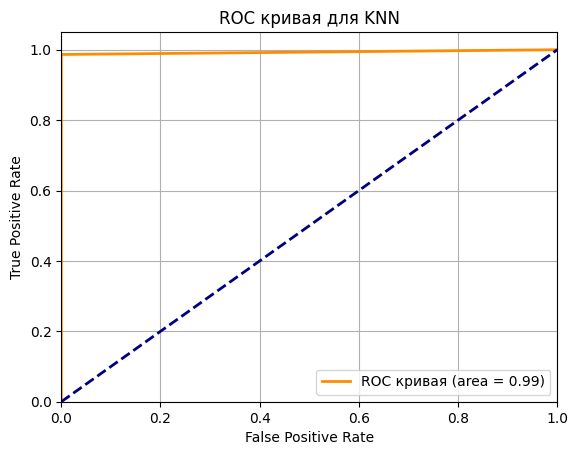

In [ ]:
# Расчет ROC
fpr, tpr, thresholds = roc_curve(y_test_reg, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Построение
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для KNN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

ROC-кривая помогает оценивать, насколько хорошо модель отличает один класс от другого. Чем выше кривая от диагонали, тем лучше модель.


Считать метрику MAE не имеет смысла, так как она применяется для оценки качества регрессионных моделей, а не классификационных.
KNN - задача классификации, предсказывает категорию или класс объекта, а MAE применяется в задачах регрессии для оценки точности числовых прогнозов.
В задаче классификации нет числовых предсказаний, которые можно было бы сравнить с реальными значениями с помощью MAE.